In [347]:
import ipywidgets as widgets
from ipywidgets import interact
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import scipy.integrate as integrate

In [348]:
#Define parameters
sim_params = {}
sim_params['Regression Degree'] = widgets.IntText(description='Regression Degree', value=5)
sim_params['Rocket Mass'] = widgets.FloatText(description='Rocket Mass (kg)', value=15)
sim_params['Gravity'] = widgets.FloatText(description='Gravity Accel', value=9.81)
sim_params['Rocket CD'] = widgets.FloatText(description='Rocket CD', value=0.3) #Value needs to be refined
sim_params['Time Precision'] = widgets.IntText(description='Time Precision', value=1000)

for widget in sim_params.values():
    display(widget)

IntText(value=5, description='Regression Degree')

FloatText(value=15.0, description='Rocket Mass (kg)')

FloatText(value=9.81, description='Gravity Accel')

FloatText(value=0.3, description='Rocket CD')

IntText(value=1000, description='Time Precision')

In [349]:
#Load thrust data
thrust_curve = np.loadtxt('./thrust_curve_CTI_910_1.txt')
thrust_time = thrust_curve.T[0]
thrust_force = thrust_curve.T[1]

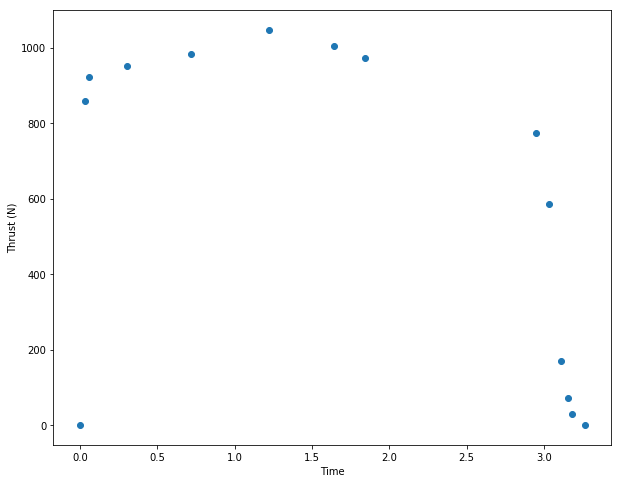

In [350]:
#Plot thrust data
plt.scatter(x=thrust_time, y=thrust_force)
plt.xlabel('Time')
plt.ylabel('Thrust (N)')

plt.gcf().set_size_inches(10, 8)
plt.show()

In [351]:
#Create polynomial feature set (takes value x and converts to [x, x^2, x^3, ...])
#Allows for polynomial regression using linear regression model
POLYNOMIAL_DEGREE = sim_params['Regression Degree'].value
polynomial_feature = PolynomialFeatures(degree=POLYNOMIAL_DEGREE)
polynomial_thrust_time = polynomial_feature.fit_transform(np.reshape(thrust_time, [-1, 1]))

print(polynomial_thrust_time.shape)

(14, 6)


In [352]:
#Fit linear regression model to polynomial time versus thrust
#TODO : Improve this, maybe ditch regression model for simpler approach (like set of trapezoids)
thrust_regression = LinearRegression()
thrust_regression.fit(polynomial_thrust_time, thrust_force)

#Define function to simplify retrieval of value
def get_thrust(t):
    time = np.resize(t, [1, 1])
    polynomial_time = polynomial_feature.fit_transform(time)
    return thrust_regression.predict(polynomial_time)[0]

Total Thrust Time: 3.2182 s
Total Thrust Impulse: 3111.015 N*s


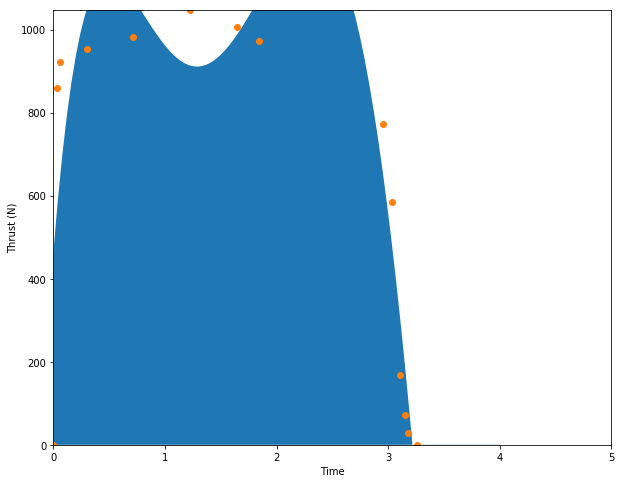

In [353]:
#Visualization of thrust regression
time_vals = np.reshape(np.linspace(0, 4, 100), [-1, 1])
predicted_thrust = [get_thrust(t) for t in time_vals]

plt.fill_between(np.reshape(time_vals, [-1]), 0, predicted_thrust)
plt.xlim(0, 5)
plt.ylim(0, max(thrust_force))

plt.scatter(x=thrust_time, y=thrust_force)
plt.xlabel('Time')
plt.ylabel('Thrust (N)')
plt.gcf().set_size_inches(10, 8)

#Find time of thrust (determine second root)
thrust_end = round(optimize.root_scalar(get_thrust, bracket=[3, 4]).root, 4)

#Find the total impulse (integration of thrust curve)
thrust_impulse = integrate.quad(lambda x: max(0, get_thrust(x)), 0, thrust_end)

print('Total Thrust Time: {} s'.format(thrust_end))
print('Total Thrust Impulse: {} N*s'.format(round(thrust_impulse[0], 3)))

In [354]:
#Define function for rocket acceleration (with positive defined as upwards)
G_ACCEL = sim_params['Gravity'].value #m/s^2
MASS = sim_params['Rocket Mass'].value
def get_acceleration(t, v):
    net_acceleration = 0
    #Thrust
    if (t <= thrust_end):
        net_acceleration += get_thrust(t) / MASS
    #Gravity
    net_acceleration -= G_ACCEL
    #Drag
    net_acceleration -= np.sign(v) * sim_params['Rocket CD'].value * (v ** 2) / MASS  
    return net_acceleration

#Define integrable acceleration function
def acceleration_model(c, t):
    x, v = c
    dx = v
    dv = get_acceleration(t, v)
    return dx, dv

In [355]:
START_POS = 0
START_VEL = 0
initial_condition = (START_POS, START_VEL)

T_PRECISION = sim_params['Time Precision'].value
t_space = np.linspace(0, thrust_end, T_PRECISION)

#Simulate burnout
r_path = integrate.odeint(acceleration_model, initial_condition, t_space)

Max Height: 136.653 m (448.36 ft)
Final Height: 136.653 m (448.36 ft)
Final Velocity: 44.11 m/s
Time Elapsed (Burnout Time): 3.218 s


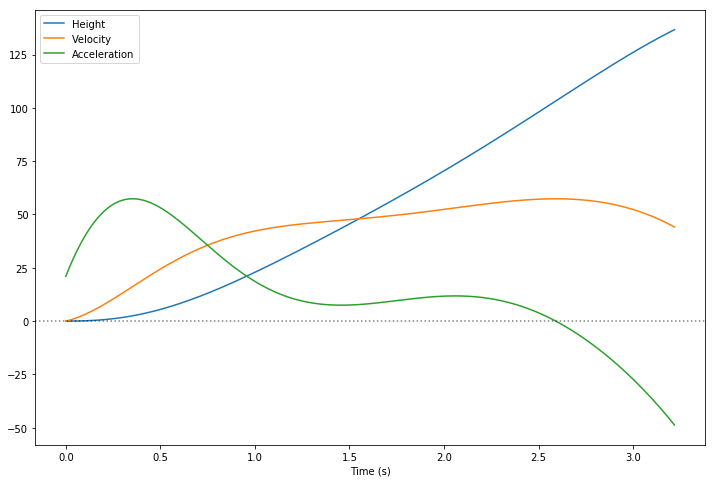

In [356]:
def plot_sim(rocket_path):
    #Plot simulated rocket ascent
    displacement_time = rocket_path.T[0]
    velocity_time = rocket_path.T[1]
    acceleration_time = [get_acceleration(x, velocity_time[index]) for index, x in enumerate(t_space)]
    
    plt.plot(t_space, displacement_time)
    plt.plot(t_space, velocity_time)
    plt.plot(t_space, acceleration_time)
    plt.xlabel('Time (s)')
    plt.legend(['Height', 'Velocity', 'Acceleration'])
    plt.gcf().set_size_inches(12, 8)
    plt.axhline(0, c='black', linestyle=':', alpha=0.5)

    plt.show()

print('Max Height: {} m ({} ft)'.format(round(max(r_path.T[0]), 3), round(max(r_path.T[0]) * 3.281, 3)))
print('Final Height: {} m ({} ft)'.format(round(r_path.T[0][-1], 3), round(r_path.T[0][-1] * 3.281, 3)))
print('Final Velocity: {} m/s'.format(round(r_path.T[1][-1], 3)))
print('Time Elapsed (Burnout Time): {} s'.format(round(thrust_end, 3)))

plot_sim(r_path)